In [1]:
from gym import make
import random
import numpy as np
from collections import namedtuple, deque
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# создаем буффер с данными, чтобы семплировать не скореллированные состояния
Transaction = namedtuple('Transaction',
                         ('state', 'action', 'next_state', 'reward'))


class Buffer(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.appendleft(Transaction(*args))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        batch = Transaction(*zip(*batch))
        self.state = torch.tensor(batch.state, dtype = torch.float)
        self.action = torch.tensor(batch.action, dtype = torch.float)
        self.next_state = torch.tensor(batch.next_state, dtype = torch.float)
        self.reward = torch.tensor(batch.reward, dtype = torch.float)

    def __len__(self):
        return len(self.memory)


In [3]:
# создаем скелеты двух сетей
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.tanh(x)


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64 + action_dim, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x, a):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(torch.cat([x, a], dim=1)))
        x = self.fc3(x)
        return x


In [4]:
# создаем шум, который будем добавлять к действиям для более качественного експлора среды
class Noise:
    def __init__(self, mu=0.0, theta=0.1, sigma=0.1):
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.action_dim = 1
        self.low = -1.0
        self.high = 1.0
        self.state = np.ones(self.action_dim) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state


In [5]:
class AQL:
    def __init__(self, states, actions, eps, episodes, batch_size, mem_sz, alpha_actor,
                 alpha_critic, gamma, tau):
        self.gamma = gamma
        self.alpha_actor = alpha_actor
        self.alpha_critic = alpha_critic
        self.eps = eps
        self.episodes = episodes
        self.batch_size = batch_size
        self.memory = Buffer(mem_sz)
        self.tau = tau
        self.noise = Noise()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.actor = Actor(states, actions).to(self.device).apply(self.weights)
        self.critic = Critic(states, actions).to(self.device).apply(self.weights)

        self.actor_target = Actor(states, actions).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic_target = Critic(states, actions).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optim = optim.Adam(self.actor.parameters(), lr=self.alpha_actor)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=self.alpha_critic)
        self.critic_criterion = nn.MSELoss()

    @staticmethod
    def weights(layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_normal_(layer.weight)

    def update(self):
        if len(self.memory) <= self.batch_size:
            return
        self.memory.sample(self.batch_size)
        Qvals = self.critic.forward(self.memory.state, self.memory.action.unsqueeze(1))
        next_actions = self.actor_target.forward(self.memory.next_state)
        next_Q = self.critic_target.forward(self.memory.next_state, next_actions.detach())
        Qprime = self.memory.reward.unsqueeze(1) + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)
        policy_loss = -self.critic.forward(self.memory.state, self.actor.forward(self.memory.state)).mean()

        self.actor_optim.zero_grad()
        policy_loss.backward()
        self.critic_optim.zero_grad()
        critic_loss.backward()

        for param_actor, param_critic in zip(self.actor.parameters(), self.critic.parameters()):
            param_actor.grad.data.clamp_(-1, 1)
            param_critic.grad.data.clamp_(-1, 1)
        self.actor_optim.step()
        self.critic_optim.step()

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

    def act(self, state):
        return np.clip(self.actor(state).detach() + self.eps * self.noise.noise(), -1.0, 1.0)


In [6]:
class Test:
    def __init__(self, path, rewards, test_episodes):
        self.rewards = rewards
        self.test_episodes = test_episodes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = torch.load(path).to(self.device)
        self.run()

    def act(self, state):
        state = torch.tensor(state, dtype = torch.float).unsqueeze(0)
        with torch.no_grad():
            return self.model(state)

    def run(self):
        env = make('MountainCarContinuous-v0')
        rewards = []
        for i in range(self.test_episodes):
            state = env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                state = next_state
            rewards.append(total_reward)
        self.test_rewards = rewards
        self.m = np.mean(rewards)

    def picture(self):
        plt.figure(figsize=(16, 16))
        ax1 = plt.subplot(421)
        ax2 = plt.subplot(422)
        ax1.plot(np.arange(0, len(self.rewards)), self.rewards, label=f'rewards')
        ax1.set_title(f'Train')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')
        ax1.legend()

        ax2.plot(np.arange(0, len(self.test_rewards)), self.test_rewards, label=f'rewards')
        ax2.axhline(y=self.m, color='r', linestyle='-', label=f'mean reward: {self.m}')
        ax2.set_title(f'Test')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Reward')
        ax2.legend()
        plt.show()


In [9]:
env = make('MountainCarContinuous-v0')
variable = 12061997
env.seed(variable)
np.random.seed(variable)
random.seed(variable)
torch.manual_seed(variable)

aql = AQL(states=env.observation_space.shape[0], actions=env.action_space.shape[0],
          eps=1.0, episodes=50, batch_size=64, mem_sz=60000,
          alpha_actor=1e-3, alpha_critic=5e-4, gamma=0.85, tau=0.45)

rewards = []
score = deque(maxlen=5)
best_score = -10000


In [10]:
for i in range(aql.episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = aql.act(torch.tensor(state, dtype = torch.float).unsqueeze(0))
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        reward += 13 * abs(next_state[1])
        aql.memory.push(state, action, next_state, reward)
        state = next_state
        aql.update()
    aql.eps *= 0.9
    score.appendleft(total_reward)
    # save best five episodes
    print(f'Episode {i},'
          f'total_reward: {total_reward},'
          f' mean five: {np.mean(score)},'
          f' total mean {np.mean(rewards)},'
          f' EPS: {aql.eps}')
    if np.mean(score) > best_score and i >= 5:
        torch.save(aql.actor, "model.pickle")
        best_score = np.mean(score)
        print('updated!!!!', best_score, '---------------------')
    rewards.append(total_reward)


Episode 0, total_reward: -80.8496206904777, mean five: -80.8496206904777, total mean nan, EPS: 0.9
Episode 1, total_reward: -68.84009220495113, mean five: -74.84485644771442, total mean -80.8496206904777, EPS: 0.81
Episode 2, total_reward: -46.1423921697793, mean five: -65.27736835506938, total mean -74.84485644771442, EPS: 0.7290000000000001
Episode 3, total_reward: 92.45502383545076, mean five: -25.844270307439345, total mean -65.27736835506938, EPS: 0.6561000000000001
Episode 4, total_reward: -88.72918451835159, mean five: -38.42125314962179, total mean -25.844270307439345, EPS: 0.5904900000000002
Episode 5, total_reward: 70.94897182621901, mean five: -8.06153464628245, total mean -38.42125314962179, EPS: 0.5314410000000002
updated!!!! -8.06153464628245 ---------------------
Episode 6, total_reward: 89.64092184337572, mean five: 23.634668163382923, total mean -20.192882320314993, EPS: 0.47829690000000014
updated!!!! 23.634668163382923 ---------------------
Episode 7, total_reward: 8

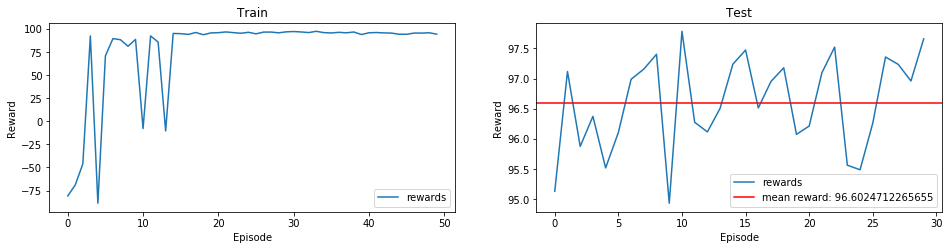

In [12]:
Test('model.pickle', rewards, 30).picture()